In [9]:
import random
import numpy as np
from copy import deepcopy
from collections import deque # pronounced 'deck'

def shuffle(l):
    for i in range(0, len(l)):
        j = random.randint(0, i)
        swap = l[i]
        l[i] = l[j]
        l[j] = swap
    return l

#### Note on the use of collections.deque

* Deques are a generalization of stacks and queues (the name is pronounced “deck” and is short for “double-ended queue”). Deques support thread-safe, memory efficient appends and pops from either side of the deque with approximately the same O(1) performance in either direction.
* Though list objects support similar operations, they are optimized for fast fixed-length operations and incur O(n) memory movement costs for pop(0) and insert(0, v) operations which change both the size and position of the underlying data representation.

# Graph Algorithms

# Undirected Graphs

In [88]:
class Graph:
    def __init__(self, V):
        """Init graph with V vertices and adjacency list adj.
        
        The adjacency list will be represented by a dictionary where the keys
        are the vertices and the values are the vertices connected to a given
        vertex.
        
        The implementation in the Java course uses bags for this, but it isn't
        clear to me what the advantage of doing so in Python would be.
        """
        self.V = V
        self.E = 0 # Number of edges
        self.adj = {v: [] for v in range(0, V)}
        
    def __repr__(self):
        graph_str = ''
        for v in self.adj.keys():
            for w in self.adj[v]:
                graph_str += f'{v} - {w}\n'
        return graph_str.strip()
        
    def add_edge(self, v, w):
        """Adds an edge between v and w.
        
        Parallel (duplicate) edges and self-loops are allowed!
        """
        self.adj[v].append(w)
        self.adj[w].append(v)
        self.E += 1l
        return

In [89]:
edges = [[0, 1],[0, 2],[0, 5],[0, 6],[3, 4],[3, 5],[4, 5],[4, 6],
         [7, 8],[9, 10],[9, 11],[9, 12],[11, 12]]

edges = shuffle(edges)
g = Graph(13)
for edge in edges:
    g.add_edge(edge[0], edge[1])

## Depth-First Search (DFS)

* Goal: Systematically search through a graph
* Outline:
    * Mark each visited vertex, recursively visit all unmarked vertices w adjacent to v
* Applications:
    * Find all vertices connected to given source vertex v
    * Find a path between two vertices
* Design pattern for graph algorithms:
    * Decouple graph representation from its processing
    * Use Graph object, build additional routines to implement algorithms 

In [58]:
class DepthFirstPaths:
    """Goal: Find all vertices connected to s, and the corresponding paths
    
    marked: a vertex-indexed list to keep track of visited vertices
    edgeTo: a vertex-indexed list to keep track of paths
    
    edgeTo[w] == v means that edge v-w taken to visit w for the first 
    time from v
    """
    def __init__(self, G, s):
        self.G = G
        self.s = s # Root of the graph of interest
        self.marked = [False for v in range(0, G.V)]
        self.edgeTo = [None for v in range(0, G.V)]
        
    def dfs(self):
        return self._dfs(self.G, self.s)
        
    def _dfs(self, G, v):
        self.marked[v] = True
        for w in self.G.adj[v]:
            if not self.marked[w]:
                self._dfs(G, w)
                self.edgeTo[w] = v
                
    def hasPathTo(self, v):
        return self.marked[v]
    
    def pathTo(self, v):
        """Finds path from the current DFS root to vertex v"""
        if not self.hasPathTo(v):
            return 'No path'
        else:
            path = deque()
            while v != self.s:
                path.appendleft(v)
                v = self.edgeTo[v]
            path.appendleft(self.s)
            return path
            

In [72]:
d = DepthFirstPaths(g, 0)
d.dfs()
d.edgeTo

[None, 0, 0, 4, 6, 3, 0, None, None, None, None, None, None]

In [73]:
d.pathTo(4)

deque([0, 6, 4])

* DFS marks all vertices connected to s in time proportional to the sum of their degrees
* After DFS, can find vertices connected to s in constant time and can find a path to s (if one exists) in time proportional to the length of the path to s
* <strong> DFS is not always the best algorithm for processing a graph!</strong> Certain types of problems lend themselves better to DFS, but for other types of problems, DFS is not the best choice at all

## Breadth-First Search (BFS)

* Similarly to DFS, BFS seeks to process all vertices connected to a vertex v
* The algorithim is entirely different though, and that makes it useful for different applications
* Goal: Systematically search through a graph
* Outline:
    * Maintain a separate queue to organise search.
        * <strong>Note that BFS is not a recursive algorithm!</strong>
    * For each vertex v, remove v from the queue of vertices to process, and enqueue all unmarked vertices adjacent to v
* Applications:
    * Finding the shortest path between s and t that uses the fewest number of edges
* BFS computes the shortest paths from s to all other vertices in the graph in time proportional to E + V
* <strong>BFS uses a queue to organise the search, while DFS uses a stack</strong>

In [79]:
class BreadthFirstPaths:
    def __init__(self, G, s):
        self.G = G
        self.s = s
        self.marked = [False for v in range(0, G.V)]
        self.edgeTo = [None for v in range(0, G.V)]
        
    def bfs(self):
        q = deque()
        q.appendleft(self.s)
        self.marked[self.s] = True
        while len(q) > 0:
            v = q.pop()
            for w in self.G.adj[v]:
                if not self.marked[w]:
                    self.marked[w] = True
                    self.edgeTo[w] = v
                    q.appendleft(w)

In [80]:
b = BreadthFirstPaths(g, 0)
b.bfs()
b.edgeTo

[None, 0, 0, 5, 6, 0, 0, None, None, None, None, None, None]

## Connected Components

* Vertices v and w are connected if there is a path between them
* A "connected component" is a maximal set of connected vertices
* Goal: pre-process a graph to answer whether v is connected to w in constant time
* Can't use the adjacency list approach from the above path-oriented algorithms--time complexity would be way too high
    * Although, you can still use a DFS-based approach
* Key idea is that connections are an <strong>equivalence relationship</strong>
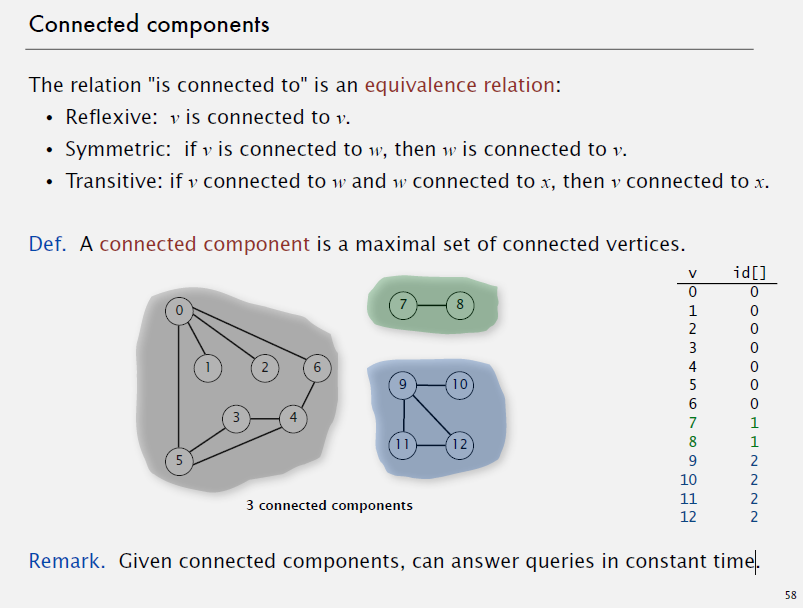

#### Implementation

* Goal is to partition vertices into connected components
* Initialise all vertices as unmarked
* For each unmarked vertex, run DFS to find all vertices connected to it

In [407]:
class CC:
    def __init__(self, G):
        self.G = G
        self.marked = [False for v in range(0, G.V)]
        self.cc = [None for v in range(0, G.V)]
        self.count = 0
        
    def __repr__(self):
        cc = ''
        for v in range(0, self.G.V):
            cc += f'{v} - {self.cc_id(v)}\n'
        return cc.strip()
        
    def _dfs(self, v):
        self.marked[v] = True
        self.cc[v] = self.count
        for w in self.G.adj[v]:
            if not self.marked[w]:
                self._dfs(w)
                
    def get_cc(self):
        for v in range(0, self.G.V):
            if not self.marked[v]:
                self._dfs(v)
                self.count += 1
                
    def cc_count(self):
        return self.count
    
    def cc_id(self, v):
        return self.cc[v]

In [408]:
cc = CC(g)
cc.get_cc()
print(cc)

0 - 0
1 - 0
2 - 0
3 - 0
4 - 0
5 - 0
6 - 0
7 - 1
8 - 1
9 - 2
10 - 2
11 - 2
12 - 2


## Common Issues and Challenges with Graphs

A common issue with graph processing is figuring out how difficult a problem you're facing. Some are deceptively easy, some that seem easy are impossible.

1. Is a graph bipartite?
    * A bipartite graph is one where the vertices can be divided into two subsets such that each edge connects a vertex in one subset to a vertex in the other
    * The 'Kevin Bacon' number is a typical application
    * Reasonably simple, but not trivial, DFS can be used
2. Find a cycle in a graph
    * Trivial, especially making use of DFS
3. Bridges of Konigsberg (Eulerian Cycles)
    * Famous problem in graph processing that seeks to answer the question of whether there is a cycle in a graph that uses each edge exactly once?
    * Answer is yes if all vertices have even degree
    * Finding such a cycle is somewhat more complex, but is possible
    * Called an 'Eulerian tour'
4. Find a cycle that visits each vertex exactly once (the traveling salesperson problem)
    * This one may seem easier than the Eulerian Cycle, but it's actually intractable!
    * Classic NP-complete problem (Hamiltonian cycle)
5. Given two graphs, are they identical except for vertex names?
    * Graph isomorphism problem
    * Longstanding open problem, no one knows whether there's an easy solution or not
6. Can a graph be laid out on a plane without crossing edges?
    * Very complex, but a linear time algorithm based on DFS does exist

# Directed Graphs

* <strong>Digraph:</strong> Set of vertices connected pairwise by *directed* edges
    * Contrast with undirected graphs, where the edges are bidirectional
    * Vertices in digraphs have outdegree and indegree
* Many applications where the direction of connection between objects is important
* Processing digraphs is more complex than undirected graphs

In [202]:
class Digraph:
    """Identical to unidirected graph, except for addEdge"""
    def __init__(self, V):
        self.V = V
        self.E = 0
        self.adj = {v:[] for v in range(0, V)}
        
    def __repr__(self):
        g = ''
        for v in range(0, self.V):
            for w in self.adj[v]:
                g += f'{v} -> {w}\n'
        return g.strip()
        
    def addEdge(self, v, w):
        """Note that here, we only add an edge from v to w, whereas before,
        we added a second edge from w to v as well
        """
        self.adj[v].append(w)
        self.E += 1
        return

In [203]:
di_edges = [[0, 1],[0, 5],[0, 6],[3, 4],[3, 5],[4, 5],[4, 6],[7, 8],[9, 10],[9, 11],[9, 12],[11, 12],[5, 2],[2, 4]]

edges = shuffle(di_edges)
g = Graph(13)
for edge in edges:
    g.add_edge(edge[0], edge[1])

dg = Digraph(13)
for edge in edges:
    dg.addEdge(edge[0], edge[1])
print(dg)

0 -> 6
0 -> 5
0 -> 1
2 -> 4
3 -> 4
3 -> 5
4 -> 6
4 -> 5
5 -> 2
7 -> 8
9 -> 10
9 -> 11
9 -> 12
11 -> 12


## DFS in Digraphs

* Problem: Final all vertices reachable from s along a directed path
* The DFS algorithm implemented above is actually a digraph algorithm! It just looks at the available edges, except that in an undirected graph, there are always two edges created, whereas in a directed graph, that's not always the case.
    * Bottom line though is that the processing algorithm is exactly the same
* DFS enables direct solution of simple digraph problems:
    * Reachability
    * Path finding
    * Topological sort
    * Directed cycle detection
* And it's the basis for solving more complex digraph problems:
    * 2-satisfiability
    * Directed Euler path
    * Strongly-connected components

## BFS in Digraphs

* Again, BFS is really a digraph algorithm, and the same method as for undirected graphs can be applied here as well
* <strong>BFS computes shortest paths from s to all other vertices in a digraph in time proportional to V + E</strong>
    * Can also use BFS to solve the multiple-source shortest path problem (initialise BFS by putting all source vertices in set on queue)
    
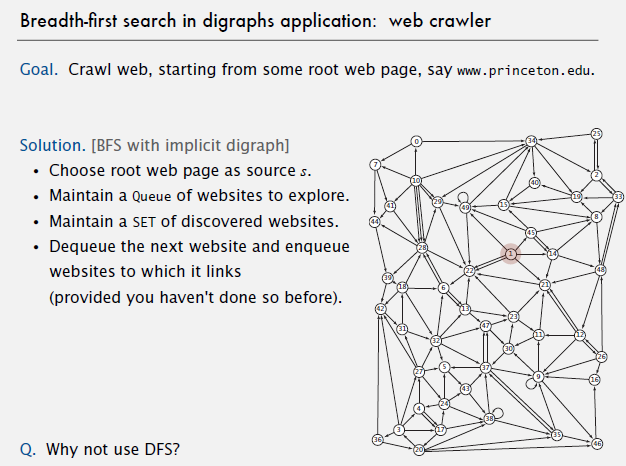

## Topological Sort

Goal: Given a set of tasks to be completed with precedence constraints, in which order should we schedule the tasks?
* Digraph model: vertex = task, edge = precedence constraint
* Topological sort works on <strong>directed acyclic graphs (DAGs)</strong>
    * If there's a cycle in the graph, you can't solve the problem!
* Approach: redraw DAG so all edges point upwards
    * Perform DFS on the graph starting from the first vertex
    * Add vertices to a stack <strong>as they are returned--this is called reverse post order</strong>
    * Return the stack after checking all vertices--this stack contains the topologically sorted vertices

## Directed Cycle Detection

If a directed graph has a cycle, it has no topological order
* How to solve? DFS, again.
Cycle detection is very important in programming
* Consider a set of classes where at some point a class inherits from a class earlier in a cycle: A -> B -> C -> A
* In a digraph, you have a cycle if, at any point in a DFS, you would call DFS on a vertex more than once in a single call stack
    * Note that by keeping track of marked vertices, you would never actually call DFS again (that would cause infinite recursion), but if you would otherwise call it, you have a cycle

In [423]:
class DepthFirstDigraph:
    def __init__(self, G, s):
        self.G = G
        self.s = s
        self.marked = [False for v in range(0, G.V)]
        self.edgeTo = [None for v in range(0, G.V)]
        self.onStack = [False for v in range(0, G.V)]
        self.cycle = []
        self.postorder = []
        
    def dfs(self):
        for s in self.s:
            self._dfs(self.G, s)
        return 
    
    def _dfs(self, G, v):
        self.marked[v] = True
        self.onStack[v] = True
        for w in self.G.adj[v]:
            if len(self.cycle) > 0:
                return
            elif not self.marked[w]:
                self.edgeTo[w] = v
                self._dfs(G, w)
            elif self.onStack[w]:
                cycle = deque()
                x = v
                while x != w:
                    cycle.append(x)
                    x = self.edgeTo[x]
                cycle.append(w)
                cycle.append(v)
                if self._check_cycle(cycle):
                    self.cycle = cycle
                    print(f'Cycle detected: {self.cycle}')
        self.onStack[v] = False
        self.postorder.append(v)
    
    def _check_cycle(self, cycle):
        """Verifies that a cycle is really a cycle"""
        first, last = -1, -1
        for v in cycle:
            if first == -1:
                first = v
            last = v
        if first != last:
            return False
        return True
    
    def detect_cycles(self):
        for v in range(0, self.G.V):
            if not self.marked[v] and len(self.cycle) == 0:
                self._dfs(self.G, v)
    
    def topological_order(self):
        """The reverse postorder of a DAG is called the topological order"""
        if len(self.postorder) == 0:
            self.dfs()
        if len(self.cycle) > 0:
            return 'Cycle detected--Digraphs with cycles have no topological order'
        return self.postorder[::-1]

In [181]:
di_edges = [[0, 1],[0, 5],[0, 6],[3, 4],[3, 5],[4, 5],[4, 6],[7, 8],[9, 10],[9, 11],[9, 12],[11, 12],[5, 2],[12,9]]
dg = Digraph(13)
for edge in di_edges:
    dg.addEdge(edge[0], edge[1])

In [182]:
dfs = DepthFirstDigraph(dg, {0, 7, 9})

In [183]:
dfs.detect_cycles()

Cycle detected: deque([12, 11, 9, 12])


## Strong Components

* Vertices v and w are strongly connected if there is a directed path from v to w and a directed path from w to v
* A strong component is a maximal subset of strongly-connected vertices
    * In a DAG, the number of strong components equals the number of vertices, because two vertices being in the same strong component implies a cycle at some point. Since a DAG by definition has no cycles, each vertex is in its own strong component.
    
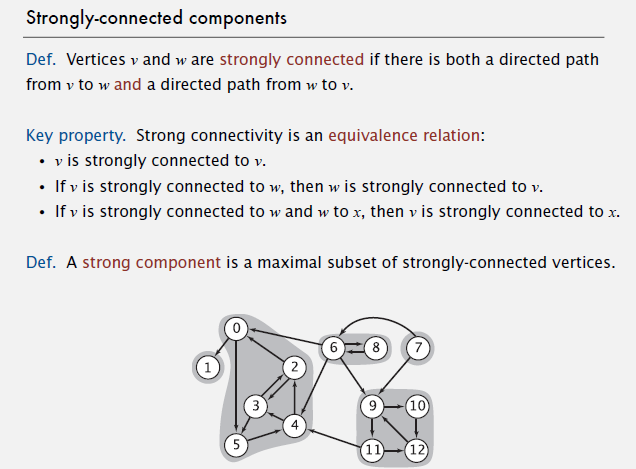

### Strong Components vs Connected Components

* Just like in undirected graphs, you can find all strong components in a directed graph in linear time
* <strong>Kosaraju-Sharir Algorithm</strong>
    * Two-pass DFS algorithm to find all strong components in time proportional to V + E (linear time)
    * Step 1: run DFS on the <strong>reverse</strong> of G to compute the reverse postorder of G
    * Step 2: run DFS on G, considering the vertices in the reverse postorder from Step 1
    
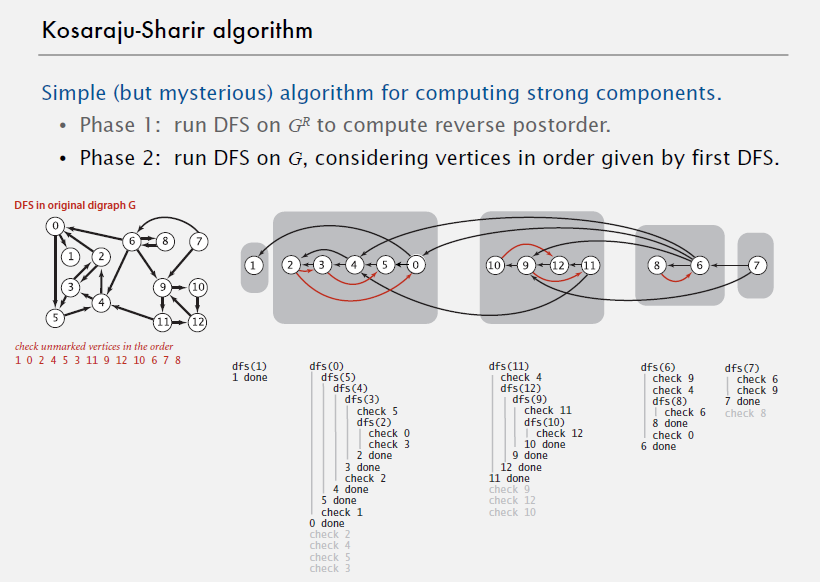

https://eli.thegreenplace.net/2015/directed-graph-traversal-orderings-and-applications-to-data-flow-analysis/

In [424]:
class SCCDigraph:
    """Adding some functionality to support SCC:
    
    1. reverse method
    2. reverse_postorder attribute
    """
    def __init__(self, V):
        self.V = V
        self.E = 0
        self.adj = {v:[] for v in range(0, V)}
        self.marked = [False for v in range(0, V)]
        self.postorder = []
        
    def __repr__(self):
        g = ''
        for v in range(0, self.V):
            for w in self.adj[v]:
                g += f'{v} -> {w}\n'
        return g.strip()
        
    def addEdge(self, v, w):
        """Note that here, we only add an edge from v to w, whereas before,
        we added a second edge from w to v as well
        """
        self.adj[v].append(w)
        self.E += 1
        return
    
    def reverse(self):
        """Reverses the digraph"""
        adj_copy = deepcopy(self.adj)
        for v in range(0, self.V):
            for w in adj_copy[v]:
                self.adj[w].append(v)
                self.adj[v].remove(w)
    
    def get_postorder(self):
        """Gets the reverse postorder"""
        if len(self.postorder) > 0:
            return
        self.reverse()
        for v in range(0, self.V):
            if not self.marked[v]:
                self._dfs(v)
        self.reverse()
    
    def _dfs(self, v):
        """DFS to support get_reverse_postorder"""
        self.marked[v] = True
        for w in self.adj[v]:
            if not self.marked[w]:
                self._dfs(w)
        self.postorder.append(v)

class SCC:
    def __init__(self, G):
        self.G = G
        self.scc = [None for v in range(0, G.V)]
        self.marked = [False for v in range(0, G.V)]
        self.count = 0
    
    def KosarajuSCC(self):
        self.G.get_postorder()
        reverse_postorder = self.G.postorder[::-1]
        for v in reverse_postorder:
            if not self.marked[v]:
                self._dfs(v)
                self.count += 1

    def _dfs(self, v):
        self.marked[v] = True
        self.scc[v] = self.count
        for w in self.G.adj[v]:
            if not self.marked[w]:
                self._dfs(w)

In [425]:
dg = SCCDigraph(13)
di_edges = [[4,2],[2,3],[3,2],[6,0],[0,1],[2,0],[11,12],[12,9],[9,10],[9,11],
           [7,9],[10,12],[11,4],[4,3],[3,5],[6,8],[8,6],[5,4],[0,5],[6,4],
           [6,9],[7,6]]
for edge in di_edges:
    dg.addEdge(edge[0], edge[1])

In [427]:
scc = SCC(dg)

In [428]:
scc.KosarajuSCC()
scc.scc

[1, 0, 2, 3, 4, 11, 9, 12, 10, 6, 8, 7, 5]


[1, 0, 1, 1, 1, 1, 3, 4, 3, 2, 2, 2, 2]

## Spanning Trees

* Given an undirected graph with positive edge weights, a spanning tree is <strong>a subgraph that is both a tree (connected and acyclic) and spanning (includes all of the vertices)</strong>
* Related problem: Find the spanning tree with the minimum weight (the minimum spanning tree)
    * How to find the MST?
        * Brute force: Check all possible spanning trees, check for lowest weight
* A <strong>cut</strong> of a graph is a partition of its vertices into two non-empty sets
* A <strong>crossing edge</strong> connects a vertex in one set with a vertex in another
* <strong>Cut Property:</strong> Given any cut, the crossing edge of minimum weight is in the MST

### Minimum Spanning Tree - Greedy Algorithm

* Assumptions:
    * Edge weights are distinct
    * Graph is connected
    * --> This means that a MST exists and that it is unique
* Algorithm:
    * Start with all edges colored grey
    * Find a cut with no black crossing edges; color its minimum weight edge black
    * Repeat until V - 1 edges are colored black
* How does this work?
    * Any edge colored black is in the MST (via the cut property)
    * While there are fewer than V - 1 black edges, there still exists at least one cut with no black crossing edges
* Implementations:
    * Kruskal's algorithm
    * Prim's algorithm
    * Boruvka's algorithm
* What if assumptions don't hold?
    * Edge weights are not distinct: means there are multiple MSTs, but the greedy algorithm still works
    * Graph is not connected: output will be a <strong>minimum spanning forest</strong>, which is just the MST of each connected component
    
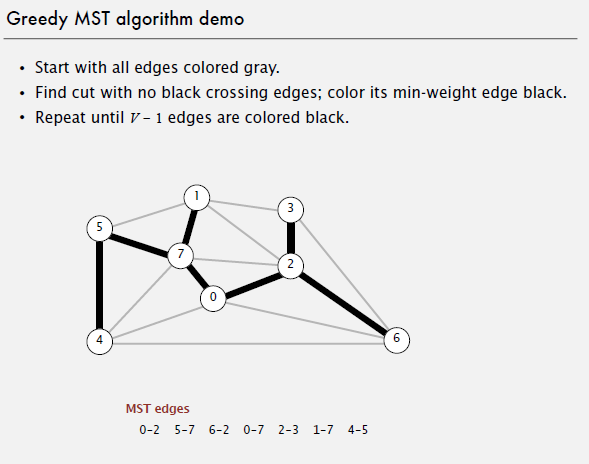

In [36]:
class Edge:
    """For graphs with weighted edges, need an abstraction for edges.
    
    Idiom for processing an edge:
    
    v = edge.either()
    w = edge.other(v)
    
    This enables processing algorithms without needed to access instance 
    variables directly or declare a convention for which vertex to return
    """
    def __init__(self, v, w, weight):
        self.v = v
        self.w = w
        self.weight = weight
    
    def __repr__(self):
        return f'{self.v} - {self.w} ({self.weight})'
    
    def compareTo(self, Edge):
        """Compares weight of this edge to another edge"""
        if self.weight > Edge.weight:
            return 1
        elif self.weight < Edge.weight:
            return -1
        else:
            return 0
    
    def either(self):
        """Gets either vertex"""
        return self.v
        
    def other(self, v):
        """Gets the vertex that isn't the one being passed"""
        if v == self.v:
            return self.w
        else:
            return self.v

In [105]:
class EdgeWeightedGraph:
    """Inits an edge-weighted graph
    
    Initialising a graph with the number of vertices pre-defined allows using
    vertex-indexed arrays as the internal data structure!
    """
    def __init__(self, V):
        self.V = V
        self.E = 0
        self.adj = {v: [] for v in range(0, V)}
        self.edges = []
    
    def __repr__(self):
        graph = ''
        for edge in self.edges:
            graph += f'{e}\n'
        return graph.strip()
    
    def add_edge(self, e):
        """Note that now, the adjacency list stores the edges directly"""
        v = e.either()
        w = e.other(v)
        self.adj[v].append(e)
        self.adj[w].append(e)
        self.edges.append(e)
        self.E += 1
        
    def edges(self, v):
        """Returns the edges associated with vertex v"""
        return self.adj[v]

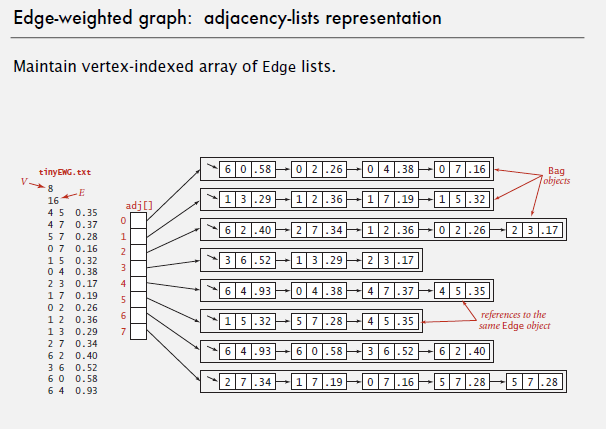

### Kruskal's Algorithm

1. Consider edges in order of ascending weight
2. Add next edge to the tree unless doing do would create a cycle

Kruskal's algorithm is really just a special case of the MST greedy algorithm. Computes the MST in time proportional to E log E. If the edges are already in order, order of growth is almost linear: E log V.

Implementation:
1. Use a priority queue to store list of edges in T
2. Use union-find data structure to check for cycles

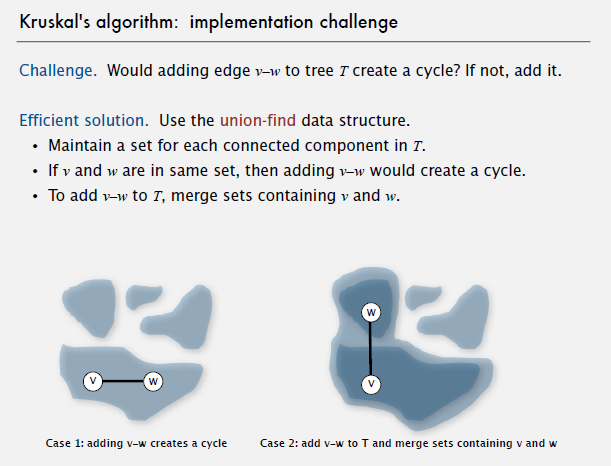

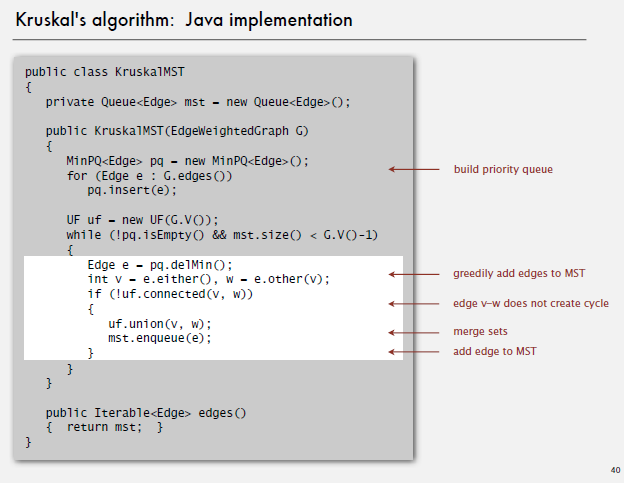

In [83]:
class UF:
    """Union-find algorithm with weighted union and path compression"""
    def __init__(self, N):
        self.id = [n for n in range(0, N)]
        self.sz = [0 for n in range(0, N)]
        
    def __repr__(self):
        return str(self.id)
        
    def _root(self, p):
        while p != self.id[p]:
            self.id[p] = self.id[self.id[p]]
            p = self.id[p]
        return p
    
    def connected(self, p, q):
        return self._root(p) == self._root(q)
    
    def union(self, p, q):
        i = self.id[p]
        j = self.id[q]
        if i == j:
            return
        if self.sz[i] > self.sz[j]:
            self.id[i] = j
            self.sz[j] += self.sz[i]
        else:
            self.id[j] = i
            self.sz[i] += self.sz[j]
            
class EdgePQ:
    """Min-oriented priority queue using a binary heap"""
    def __init__(self):
        self.pq = [Edge(np.nan, np.nan, np.nan)]
        self.current_size = 0
        
    def insert(self, i):
        self.pq.append(i)
        self.current_size += 1
        self._swim(self.current_size)
    
    def _is_smaller(self, k, j):
        """Compares two Edges at positions k and j in the PQ"""
        return self.pq[k].weight < self.pq[j].weight
    
    def _swim(self, k):
        while k > 0 and self._is_smaller(k, k // 2):
            self._swap(k, k // 2)
            k = k // 2
            
    def _sink(self, k):
        while 2 * k <= self.current_size:
            j = 2 * k
            if j < self.current_size and self._is_smaller(j + 1, j):
                j += 1
            if self._is_smaller(k, j):
                break
            self._swap(k, j)
            k = j
            
    def _swap(self, i, j):
        swap = self.pq[i]
        self.pq[i] = self.pq[j]
        self.pq[j] = swap
        
    def del_min(self):
        if self.is_empty():
            return
        pq_min = self.pq[1]
        self._swap(1, self.current_size)
        self.pq = self.pq[:-1]
        self.current_size -= 1
        self._sink(1)
        return pq_min
        
    def is_empty(self):
        return len(self.pq) == 1

In [89]:
class KruskalMST:
    """As before, algorithms are implemented in separate client classes"""
    def __init__(self, G):
        self.G = G
        self.weight = 0
        self.mst = deque()
        self.edge_pq = self._build_edge_pq() #Init edge PQ (already sorted)
        self.uf = UF(G.V) #Init union-find to check for cycles
        
    def _build_edge_pq(self):
        pq = EdgePQ()
        for edge in self.G.edges:
            pq.insert(edge)
        return pq
    
    def build_mst(self):
        while not self.edge_pq.is_empty() and len(self.mst) < self.G.V - 1:
            e = self.edge_pq.del_min()
            v = e.either()
            w = e.other(v)
            if not self.uf.connected(v, w):
                self.uf.union(v, w)
                self.mst.appendleft(e)
                self.weight += e.weight
    
    def edges(self):
        return self.mst    

In [106]:
g = EdgeWeightedGraph(8)
edges = [[0, 7, 0.16],
[2, 3, 0.17],
[1, 7, 0.19],
[0, 2, 0.26],
[5, 7, 0.28],
[1, 3, 0.29],
[1, 5, 0.32],
[2, 7, 0.34],
[4, 5, 0.35],
[1, 2, 0.36],
[4, 7, 0.37],
[0, 4, 0.38],
[6, 2, 0.40],
[3, 6, 0.52],
[6, 0, 0.58],]
shuffled = shuffle(edges)
for e in shuffled:
    edge = Edge(e[0], e[1], e[2])
    g.add_edge(edge)

In [91]:
mst = KruskalMST(g)
mst.build_mst()
mst.edges()

deque([6 - 2 (0.4),
       4 - 5 (0.35),
       5 - 7 (0.28),
       0 - 2 (0.26),
       1 - 7 (0.19),
       2 - 3 (0.17),
       0 - 7 (0.16)])

### Prim's Algorithm

Approach:
* Start with vertex 0 and greedily grow tree T
* Add to T the min weight edge with exactly one endpoint in T
* Repeat until you have V - 1 edges in T

Prim's algorithm is another special case of the greedy MST algorithm

Implementation (Lazy):
* Maintain a priority queue of edges with at least one endpoint in T
* Use delete min to determine the next edge to add
* Disregard if both endpoints are already in T (this is why the implementation is 'lazy'--edges are allowed to remain on the priority queue even though we may know they won't be used)
* Otherwise, let w be the vertex not in T:
    * Add to the PQ any edge incident to w (if other endpoint not in T)
    * Add w to T
    
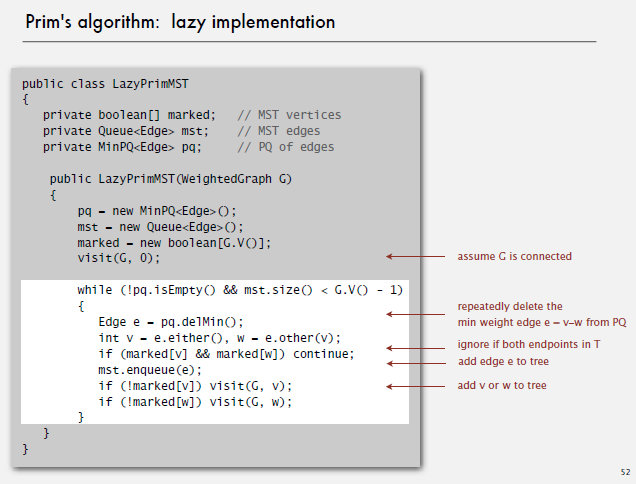

Running time is proportional to E log E in the worst case. Also uses extra space proportional to E though (see below).

In [131]:
class PrimLazyMST:
    """Implements the lazy version of Prim's MST algorithm"""
    def __init__(self, G):
        self.G = G
        self.marked = [False for v in range(0, G.V)]
        self.mst = deque()
        self.edge_pq = EdgePQ()
        
    def build_mst(self):
        """Builds MST"""
        self._visit(self.G, 0) #Start at vertex 0
        
        while not self.edge_pq.is_empty() and len(self.mst) < self.G.V - 1:
            edge = self.edge_pq.del_min()
            v = edge.either()
            w = edge.other(v)
            if self.marked[v] and self.marked[w]:
                continue
            else:
                self.mst.appendleft(edge)
            if not self.marked[v]:
                self._visit(self.G, v)
            if not self.marked[w]:
                self._visit(self.G, w)
    
    def _visit(self, G, v):
        """Visits vertex v on graph G to add to MST"""
        self.marked[v] = True
        for edge in self.G.adj[v]:
            w = edge.other(v)
            if not self.marked[w]:
                self.edge_pq.insert(edge)
                
    def edges(self):
        return self.mst

In [132]:
mst = PrimLazyMST(g)
mst.build_mst()
mst.edges()

deque([6 - 2 (0.4),
       4 - 5 (0.35),
       5 - 7 (0.28),
       2 - 3 (0.17),
       0 - 2 (0.26),
       1 - 7 (0.19),
       0 - 7 (0.16)])

### Prim's Algorithm - Eager Implementation

In practice, the lazy implementation of Prim's algorithm is usually fine, but to make it more efficient, the priority queue can be refactored to use vertices instead of edges.

Too complicated to implement (not in the slides either), but possibly good to know it's possible to get the running time down to E log V using the eager approach, which can be significant in certain situations.

# Shortest Paths

Problem statement: Given an edge-weighted digraph, find the shortest path from s to t.

Variants:
* Single source: from one vertex s to every other vertex
* Source-sink: from one vertex s to another vertex t
* All pairs: between all pairs of vertices

## Single-source Shortest Paths

Problem: Find the shortest path from s to every other vertex

Data Structures:
* Use two vertex-indexed arrays:
    * distTo[v]: length of the shortest path from s to v
    * edgeTo[v]: the last edge on the shortest path from s to v (traceback edges to find complete path from s to v)
    
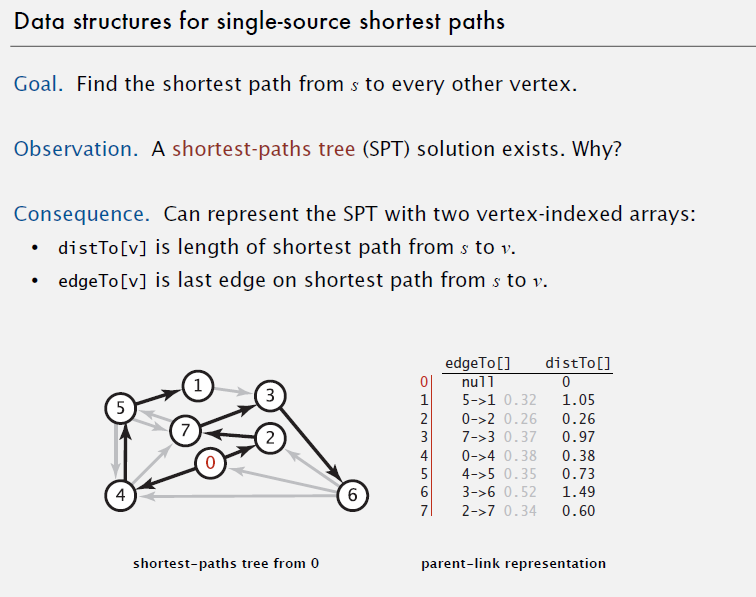

### Single-source Shortest Paths Algorithms

<strong>Edge relaxation:</strong> refers to the concept of updating the data structures to take into account any newly-encountered edges, if those new edges create a new shortest path to a vertex previously encountered.

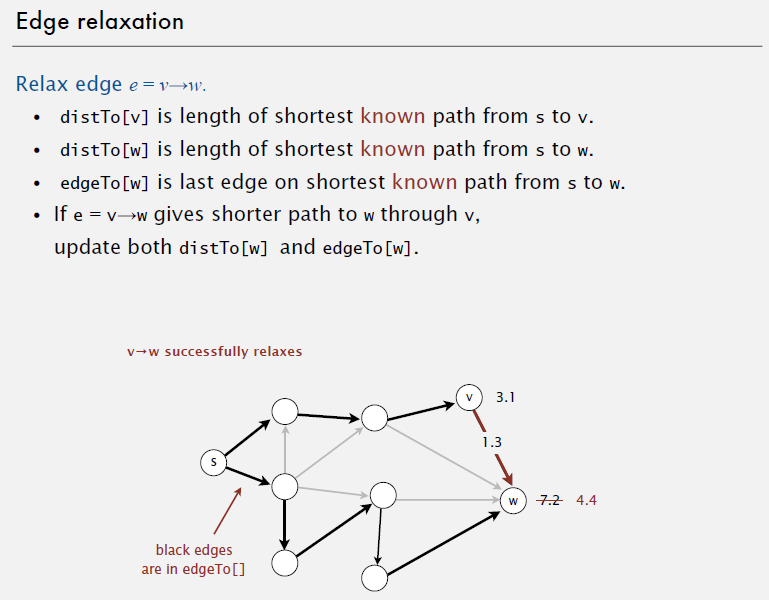

<strong>Shortest-paths optimality conditions:</strong>
* To be sure we have the shortest paths, the following two conditions must be true:
1. For each vertex v, distTo[v] is the length of some path from s to v
2. For each edge e (v -> w), distTo[w] <= distTo[v] + e.weight

<strong>If the optimality conditions are met, you have the shortest paths!</strong>

<strong>Generic shortest-paths algorithm:</strong>
1. Initialise distTo[s] = 0 and distTo[v] = infinity for all other vertices
2. Relax any edge
3. Repeat Step 2 until optimality conditions are satisifed

So, all you have to do really is figure out how to efficiently choose which edge to relax!

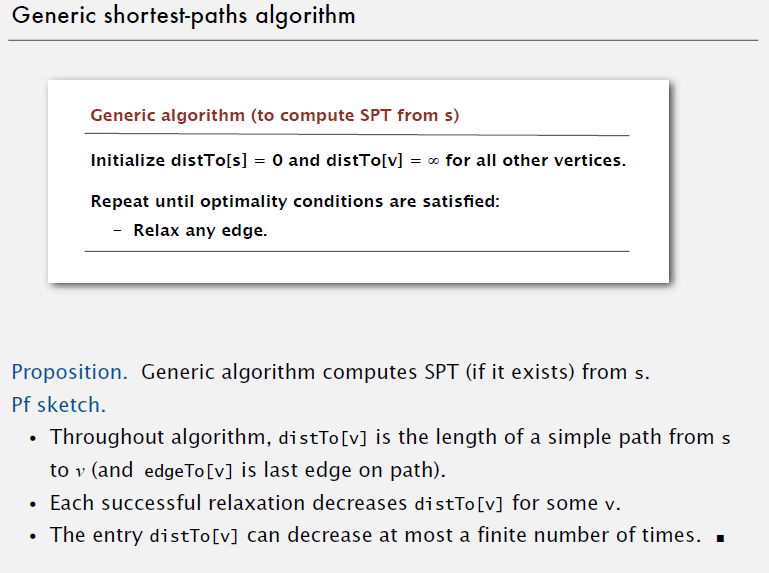

## Dijkstra's Algorithm

Dijkstra's algorithm works for finding the shortest paths in an edge-weighted digraph with non-negative weights.

Approach:
1. Starting with the source, choose the vertex closest to the source (initially, the source itself)
2. Add that vertex to the shortest-paths tree, then relax all edges pointing from that vertex

How does this work?
* By always choosing the next-closest vertex to the source, the algorithm guarantees that there is no shorter path from the vertex to that source, because all previous edges from the source have been relaxed.

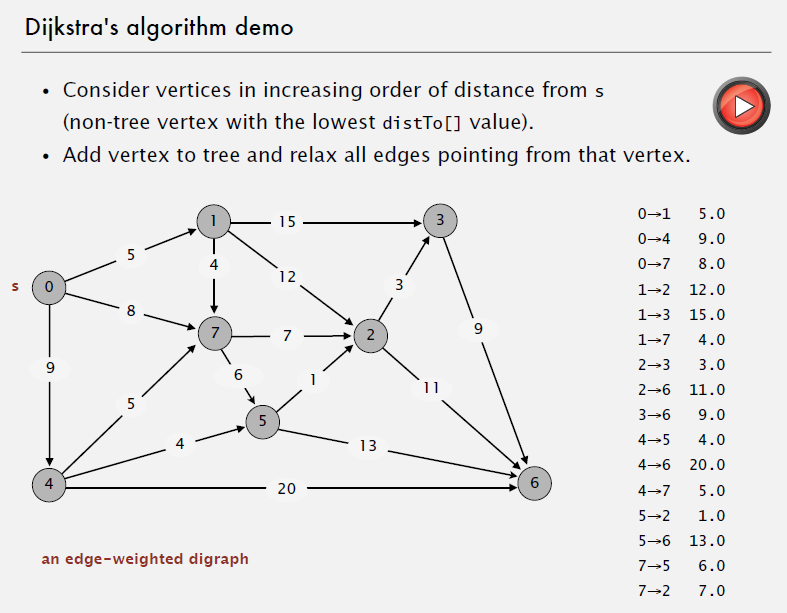

#### Implementation Note:

Dijkstra's algorithm can be implemented storing the vertices on an unordered array, but for large sparse graphs like those often encountered in practice, that's not a workable solution because finding the next closest vertex to the source requires searching the entire array of possible vertices (runtime is V^2).

So, a better approach is to use a priority queue, as with Prim's algorithm above. 

For Dijkstra's algorithm though, you need a way to change the priority of the keys in the priority queue during the 'relax edge' operation. Heaps typically don't support accessing any element other than the min (or max) in any less than O(n) time, which is not efficient.

So, the priority queue data structure needs to be altered to support accessing and modifying any key in constant time. This can be accomplished using an 'indexed priority queue.'

Why do we need to change the key value? 
* Consider the key values are physical distances.
* Dijkstra's algorithm says to look at the next-closest vertex to the source, and relax all edges coming from that vertex
* <strong>The order of vertices to visit is stored on a priority queue, but THAT ORDER MAY CHANGE depending on subsequent edge relaxtions!</strong> If relaxing an edge gives a shorter path to a vertex already seen, the order in which the algorithm needs to consider that vertex changes (ie, it's closer to the source and should be considered sooner).
* Heaps don't normally allow accessing objects other than the minimum (or maximum, in a max heap) in constant time. You'd need to iterate through all objects in the heap to find the onw you're interested in, which takes too long--you might as well just use a standard sorted array and re-sort after every relaxtion.
* All the indexed priority queue does is give a way to access any object in the heap in constant time, given an index, and to change the key (here, the weight or distance) associated with that object.

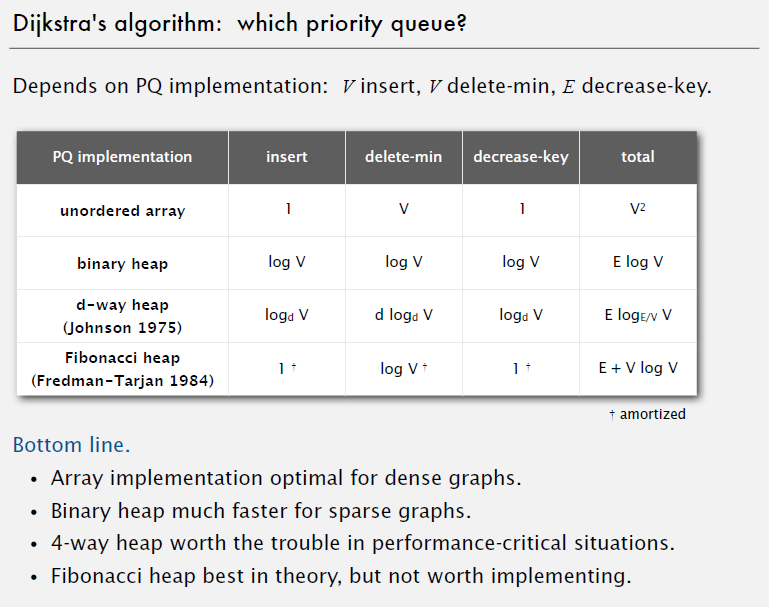

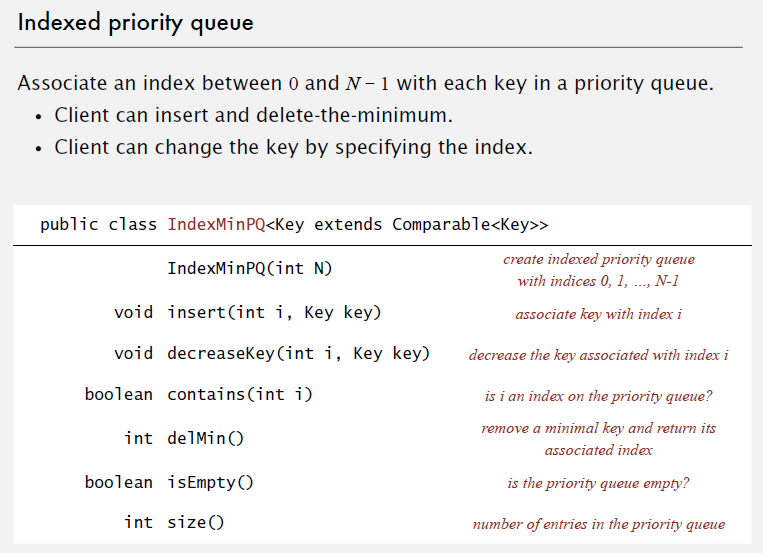

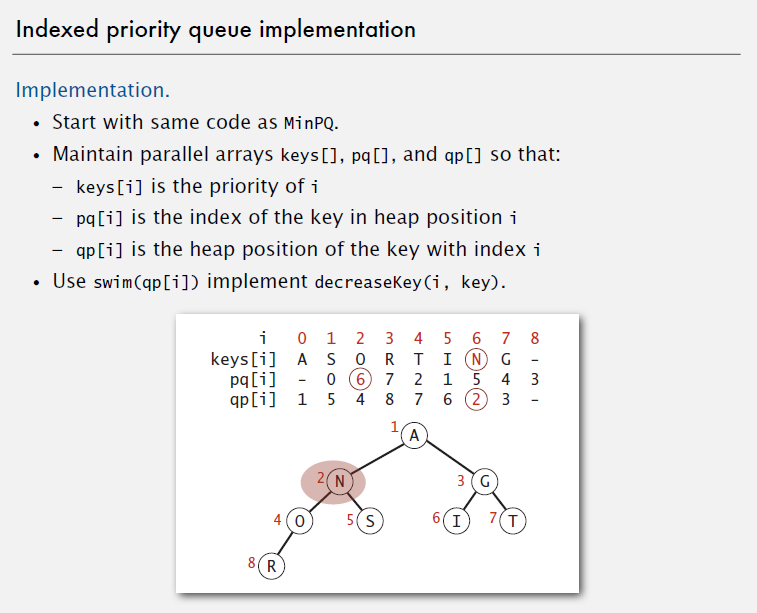

In [222]:
class IndexMinPQ:
    """An indexed minimum-oriented priority queue using a binary heap.
    
    Supports decrease_key operation needed for efficient implementation of
    Dijkstra's algorithm.
    
    keys[i] is the priority of i
    pq[i] is the index of the key in heap position i
    qp[i] is the heap position of the key with index i
    
    pq and qp are the inverse of each other!
    
    pq[qp[i]] = qp[pq[i]] = i
    
    """
    def __init__(self, N):
        self.max_size = N + 1
        self.current_size = 0
        self.keys = [np.nan for n in range(0, self.max_size)]
        self.pq = [np.nan for n in range(0, self.max_size)]
        self.qp = [-1 for n in range(0, self.max_size)]
        
    def is_empty(self):
        return self.current_size == 0
    
    def contains(self, i):
        return self.qp[i] != -1
    
    def key_of(self, i):
        return self.keys[i]
    
    def insert(self, i, key):
        self.current_size += 1
        self.keys[i] = key
        self.pq[self.current_size] = i
        self.qp[i] = self.current_size
        self._swim(self.current_size)
        
    def delete(self, i):
        """Deletes the key at index i
        
        Same general idea as delete the min, except that we're now deleting
        at an arbitrary index i:
        
        1. Exchange the key at the given index with the last key in the queue
        2. Remove references to last key in queue
        3. Make sure the swapped key is in the right position
        
        Need to sink AND swim because we're not sure where we are in the queue
        """
        index = self.qp[i]
        self._swap(index, self.current_size)
        self._swim(index)
        self._sink(index)
        self.keys[i] = np.nan
        self.qp[i] = -1
        self.current_size -= 1
        
    def del_min(self):
        if self.is_empty():
            return
        pq_min = self.pq[1]
        self._swap(1, self.current_size)
        self.pq = self.pq[:-1]
        self.current_size -= 1
        self._sink(1)
        self.qp[pq_min] = -1
        self.keys[pq_min] = np.nan
        return pq_min
    
    def change_key(self, i, key):
        """Change the key at index i to the specified value"""
        self.keys[i] = key
        self._swim(self.qp[i])
        self._sink(self.qp[i])
    
    def decrease_key(self, i, key):
        """Decreases the key at index i to the specified value
        
        1. Change key value to be something smaller
        2. SWIM the new key value because it's now SMALLER than it was before, and this is a MIN heap--the key needs to
        be HIGHER in the heap, so you need to swim the key at heap position i (ie, use the qp array)
        """
        if key >= self.keys[i]:
            print("New key is greater than existing key!")
            return
        self.keys[i] = key
        self._swim(self.qp[i])
        
    def increase_key(i, key):
        """Increases the key at index i to the specified value
        
        1. Change the key value to something larger
        2. SINK the key because it's now LARGER than it was before, and this is a MIN heap--the key needs to be LOWER in 
        the heap, so you need to sink the key at heap position i (ie, use the qp array)
        """
        if key <= self.keys[i]:
            print("New key is less than existing key!")
            return
        self.keys[i] = key
        self._sink(self.qp[i])
        
    def _is_smaller(self, k, j):
        """Comparable implementation: here, we're comparing the weights of
        two edge objects
        
        Remember, the weights are stored as keys in the keys array!
        """
        return self.keys[self.pq[k]] < self.keys[self.pq[j]]
    
    def _swap(self, i, j):
        swap = self.pq[i]
        self.pq[i] = self.pq[j]
        self.pq[j] = swap
        self.qp[self.pq[i]] = i
        self.qp[self.pq[j]] = j
        
    def _swim(self, k):
        while k > 1 and self._is_smaller(k, k // 2):
            self._swap(k, k //2)
            k = k // 2
            
    def _sink(self, k):
        while 2 * k <= self.current_size:
            j = 2 * k
            if j < self.current_size and self._is_smaller(j + 1, j):
                j += 1
            if self._is_smaller(k, j):
                break
            self._swap(k, j)
            k = j
        

In [248]:
class DirectedEdge:
    """Implementation for directed edges
    
    Idiom for processing an edge: v = e.from(), w = e.to()
    """
    def __init__(self, v, w, weight):
        self.v = v
        self.w = w
        self.weight = weight
        
    def __repr__(self):
        return f'{self.v} - {self.w} ({self.weight})'
    
    def v_from(self):
        return self.v
    
    def v_to(self):
        return self.w
    
    def weight(self):
        return self.weight
    
class EdgeWeightedDigraph:
    """Very similar to edge weighted undirected graphs"""
    def __init__(self, V):
        self.V = V
        self.adj = {v: [] for v in range(0, V)}
        self.edges = []
        
    def __repr__(self):
        s = ''
        for edge in self.edges:
            s += f'{edge}\n'
        return s.strip()
    
    def add_edge(self, edge):
        v = edge.v_from()
        self.adj[v].append(edge)
        self.edges.append(edge)
        
    def topological_sort(self):
        """Returns vertices in topological order.
        
        Recall that topological order is just the reverse post-order, ie, 
        the order in which vertices are returned from a DFS call on the graph
        """
        topological_order = deque()
        marked = [False for v in range(0, self.V)]
        self._dfs_topological(0, marked, topological_order)
        return topological_order
    
    def _dfs_topological(self, v, marked, postorder_stack):
        """Runs dfs specifically to get topological order
        
        Args:
            v: starting vertex
            marked: visited vertex array
            postorder_stack: stack to store vertex postorder
        """
        marked[v] = True
        for edge in self.adj[v]:
            w = edge.v_to()
            if not marked[w]:
                self._dfs_topological(w, marked, postorder_stack)
        postorder_stack.appendleft(v)
        

In [229]:
class DijkstraSP:
    """Single-source shortest paths API using Dijkstra's Algorithm
    
    Implements single-source version of the shortest paths problem: find paths
    from vertex s to every other vertex in the graph.
    
    G: graph object
    s: source vertex to start from
    distTo: the total distance from the source to vertex v
    edgeTo: the most recent edge connecting to vertex v (follow this back to get to the source)
    """
    def __init__(self, G, s):
        self.G = G
        self.s = s
        self.distTo = [np.inf for v in range(0, G.V)]
        self.edgeTo = [None for v in range(0, G.V)]
        self.pq = IndexMinPQ(G.V)
        
        self._calc_shortest_paths()
        
    def dist_to(self, v):
        return self.distTo[v]
    
    def path_to(self, v):
        path = deque()
        edge = self.edgeTo[v]
        while edge:
            path.appendleft(edge)
            edge = self.edgeTo[edge.v_from()]
        return path
    
    def _calc_shortest_paths(self):
        """This is the core of Dijkstra's algorithm:
        
        1. Initialise distance to the source to be 0
        2. Insert the source into the priority queue
        3. Get the vertex closest to the source
        4. Relax all edges pointing from that vertex
        """
        self.distTo[self.s] = 0.0
        self.pq.insert(self.s, 0)
        while not self.pq.is_empty():
            v = self.pq.del_min()
            for edge in self.G.adj[v]:
                self._relax(edge)
        
    def _relax(self, e):
        """Relaxes edge e (see above).
        
        If the current distance to w is greater than the distance to v plus
        the weight of the new edge connecting v and w, then you've found a 
        better way to get from s to w! Update data structures to store the new
        path.
        """
        v = e.v_from()
        w = e.v_to()
        if self.distTo[w] > self.distTo[v] + e.weight:
            self.distTo[w] = self.distTo[v] + e.weight
            self.edgeTo[w] = e
            if self.pq.contains(w):
                self.pq.decrease_key(w, self.distTo[w])
            else:
                self.pq.insert(w, self.distTo[w])

In [255]:
edges = [[0,1,5.0],
[0,4,9.0],
[0,7,8.0],
[1,2,12.0],
[1,3,15.0],
[1,7,4.0],
[2,3,3.0],
[2,6,11.0],
[3,6,9.0],
[4,5,4.0],
[4,6,20.0],
[4,7,5.0],
[5,2,1.0],
[5,6,13.0],
[7,5,6.0],
[7,2,7.0],]
shuffled = shuffle(edges)
g = EdgeWeightedDigraph(8)
for edge in shuffled:
    e = DirectedEdge(edge[0], edge[1], edge[2])
    g.add_edge(e)

In [256]:
dj = DijkstraSP(g, 0)

In [232]:
dj.distTo

[0.0, 5.0, 14.0, 17.0, 9.0, 13.0, 25.0, 8.0]

In [228]:
dj.path_to(6)

deque([0 - 4 (9.0), 4 - 5 (4.0), 5 - 2 (1.0), 2 - 6 (11.0)])

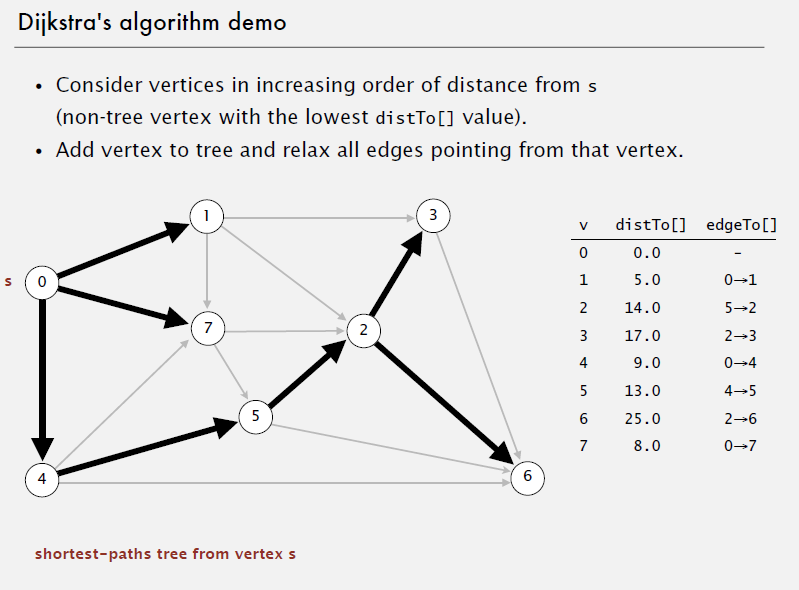

### Directed Acyclic Digraphs (Edge-Weighted DAGs)

This is a special case of digraphs, where you know there are no cycles (the graph is acyclic, or a DAG).

In this case, computing single-source shortest paths is actually easier than for a digraph that might contain cycles. All you need to do is:
1. Consider each vertex in <strong>topological order</strong>
2. Relax all edges pointing from each vertex
With an edge-weighted DAG, there's no need to use Dijkstra's algorithm at all!

Also note that with this algorithm, edge weights can even be negative (which would break Dijkstra's algorithm)

How does this work?
* distTo[w] will never increase (because distTo values are monotonically decreasing)
* distTo[v] will never change, because considering vertices in topological order means that, when you consider v, there will be no edges more pointing to v

Running time is proportional to V + E:
* Each vertex will be considered once for the topological sort
* Each edge will be relaxed exactly once during the graph processing

In [271]:
class AcyclicSP:
    """Finds single-source shortest paths for an edge-weighted DAG"""
    def __init__(self, G, s):
        self.G = G
        self.s = s
        self.edgeTo = [None for v in range(0, G.V)]
        self.distTo = [np.inf for v in range(0, G.V)]
        
        self._acyclic_sp()
        
    def _acyclic_sp(self):
        self.distTo[self.s] = 0.0
        topological_order = self.G.topological_sort()
        for v in topological_order:
            for edge in self.G.adj[v]:
                self._relax(edge)
    
    def _relax(self, edge):
        v = edge.v_from()
        w = edge.v_to()
        if self.distTo[w] > self.distTo[v] + edge.weight:
            self.distTo[w] = self.distTo[v] + edge.weight
            self.edgeTo[w] = edge
        

In [272]:
ac = AcyclicSP(g, 0)

In [273]:
ac.distTo

[0.0, 5.0, 14.0, 17.0, 9.0, 13.0, 25.0, 8.0]

### Some Interesting Applications:

* Image processing (content-aware resizing)
* Finding the <strong>longest</strong> path
    * Since the acyclic sp algorithm can handle negative weights, you can just negate all the weights, run shortest paths, and that will give you the longest path
    * Can use this idea to solve parallel job scheduling problems
    
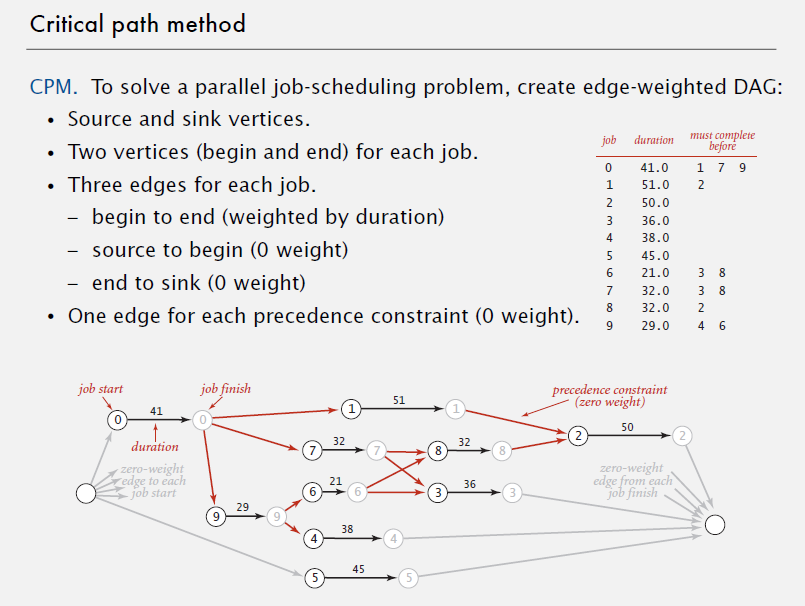

### Negative Weights in Directed Weighted Graphs

* Dijkstra's algorithm doesn't work, adding a constant to every edge to remove negatives doesn't work, topological sort won't work if there are cycles...
    * Need a new algorithm!
* <strong>Negative cycle:</strong> a directed cycle whose sum of edge weights is negative
* Implication: there is a shortest path if and only if there are no negative cycles
    * If there is a negative cycle, every loop around the cycle reduces the overall path weight, so the shortest path is infinitely negative (keep looping around the cycle reducing the weight each time)

### Bellman-Ford Algorithm (Dynamic Programming Solution)

The Bellman-Ford Algorithm can handle negative edge weights in the following way:
1. Initialise distTo[s] = 0 and distTo[v] = infinity for all other vertices
2. Repeat V times: relax all edges

This is a dynamic programming algorithm that finds the shortest path tree in time proportional to V x E

Practical improvements:
* If distTo[v] doesn't change during pass i, no need to relax any edge pointing from v in pass i + 1
* Maintain a queue of vertices whose distTo changed
* Still takes time proportional to V x E in the worst case, but runs much faster in practice

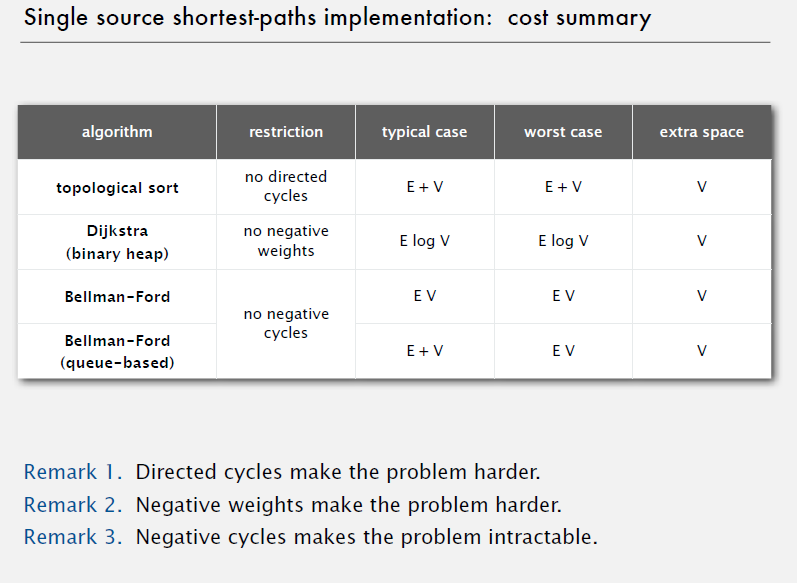

1. Topological sort can handle negative weights but not cycles
2. Dijkstra can handle cycles but not negative weights
3. <strong>No algorithm can handle negative cycles!</strong>

### Detecting Negative Cycles

* If there is a negative cycle, the Bellman-Ford algorithm will get stuck in a loop, updating distTo and edgeTo entries of vertices in the cycle
* So, to find a negative cycle, you can run the Bellman-Ford algorithm and check to see if this is happening
* One way to do it is to just check to see if any vertex v is updated in the last pass V. If so, there's a negative cycle containing v, and you can find it by tracing back edgeTo[v]
* Can also implement checking more frequently

#### Application of Negative Cycle Detection: Arbitrage Detection

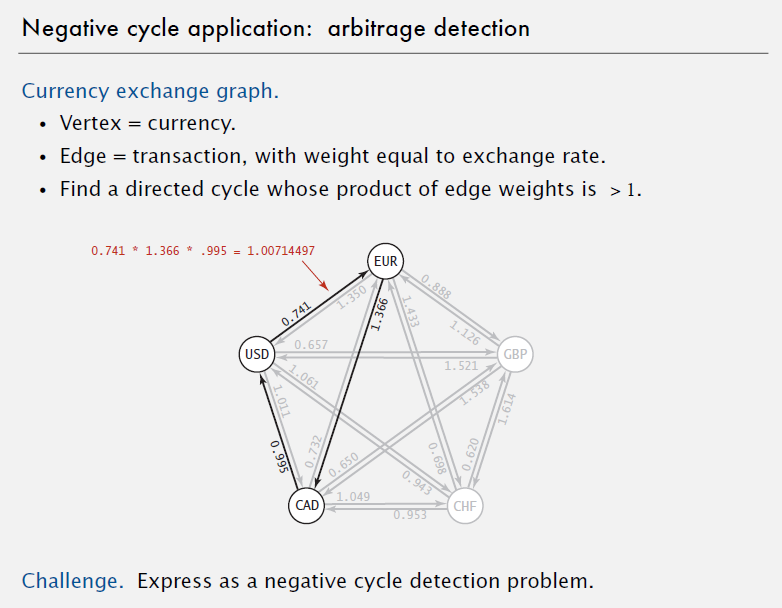

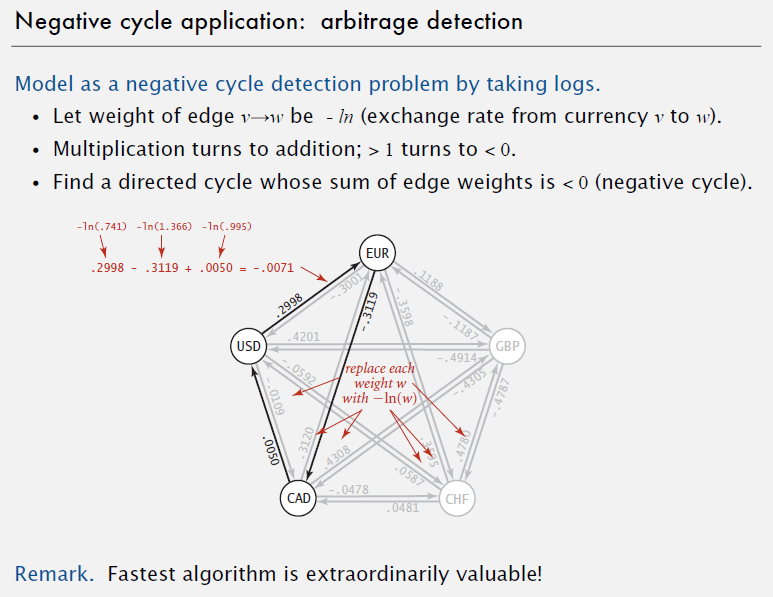

## Summary of Shortest Paths Algorithms

Shortest paths is a broadly useful problem solving model! If you can cast a problem as a shortest paths problem, you can apply these very efficient algorithms to solve the problem very effectively.

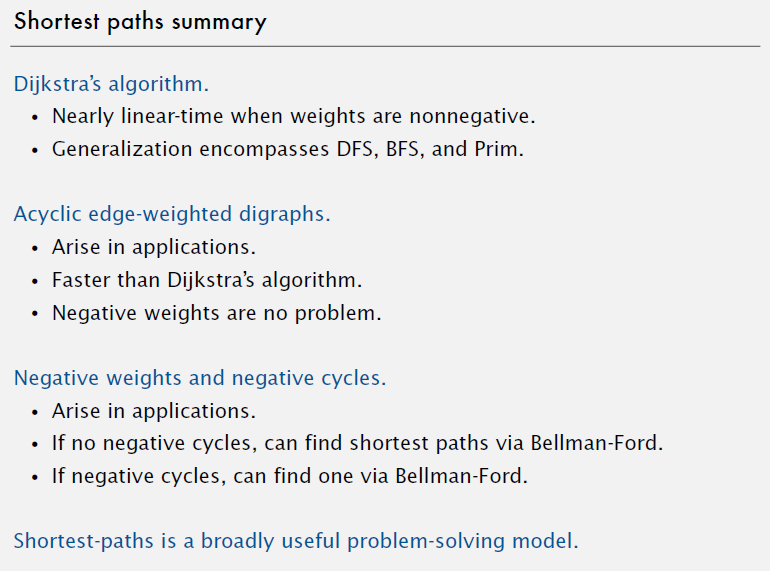

# Mincut and Maxflow Problems

## Mincut

Problem statement: Given a directed edge-weighted graph G with vertices s and t, find the 2-way cut of G such that each cut contains either s or t and some other collection of vertices, and the weight of the edges pointing from the cut containing s to the cut containing t is minimised.

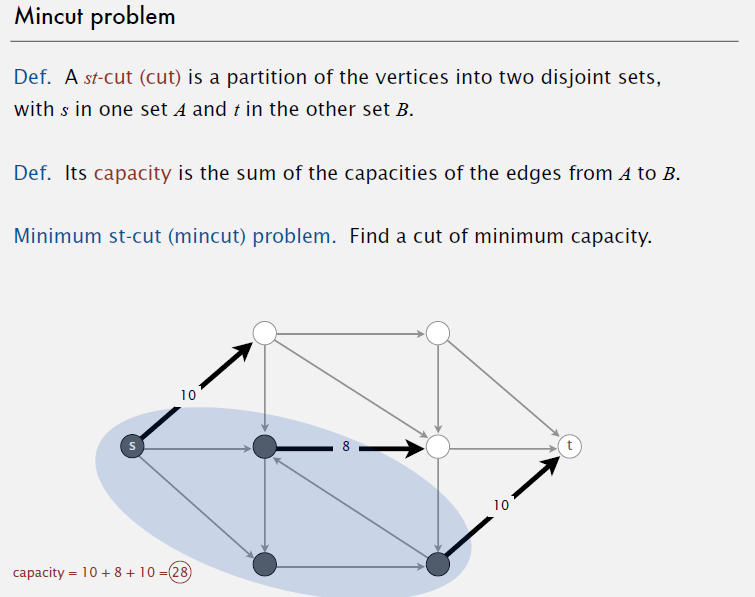

## Maxflow

A <strong>st-flow</strong> is an assignment of values to edges such that the edge's value is less than or equal to its capacity and the flow into each vertex equals the flow out of each vertex (except s and t).

Problem statement: Find the maximum value of the flow. The value of the flow is the total input into the terminal vertex t.

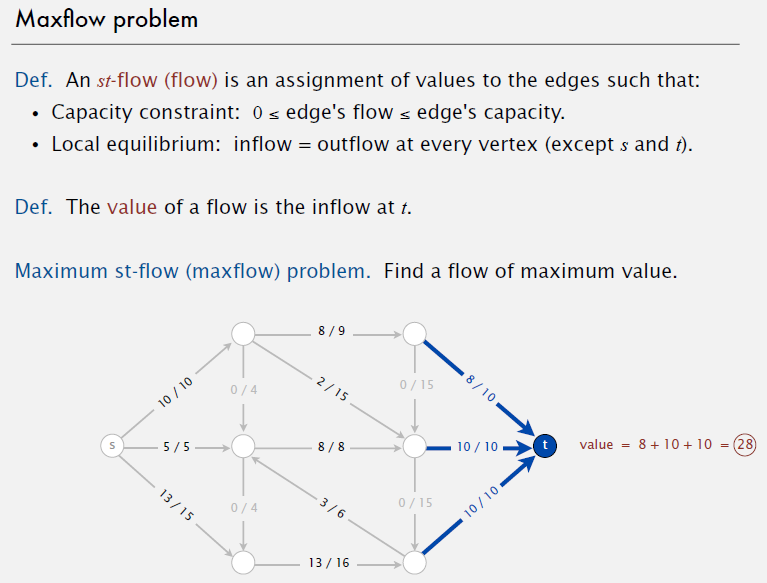

## Ford-Fulkerson Algorithm

First, it turns out that the mincut and maxflow problems are essentially the same problem.

Ford-Fulkerson algorithm:
* Initialise the graph with 0 flow
* While there is an <strong>augmenting path</strong>, find an augmenting path, compute the bottleneck capacity, and increase the flow on that path by the bottleneck capacity
    * An <strong>augmenting path</strong> is a path from s to t that increases the flow

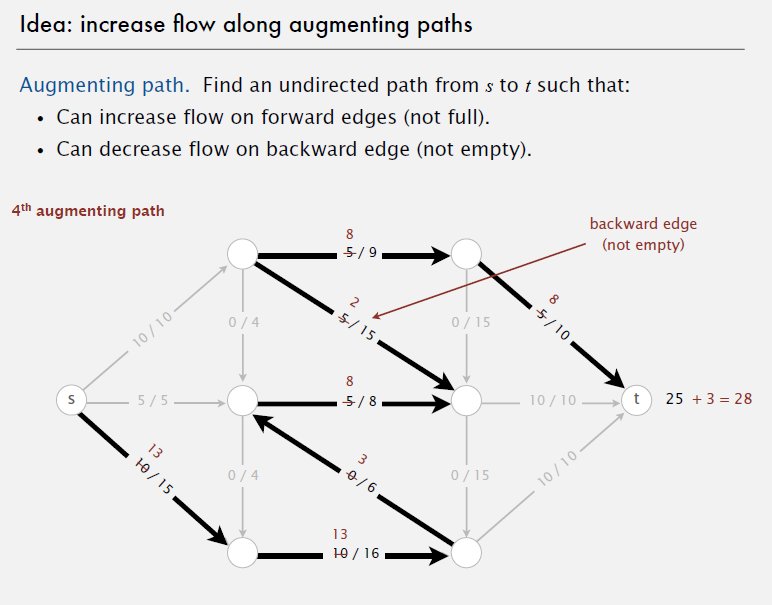

## Maxflow Mincut Theorem

The <strong>net flow</strong> across a cut (A, B) is the sum of the flows on its edges from A to B minus the sum of the flows from B to A

<strong>Flow-value lemma:</strong> Let f be any flow and let (A, B) be any cut. Then, the net flow across (A, B) equals the flow of f.

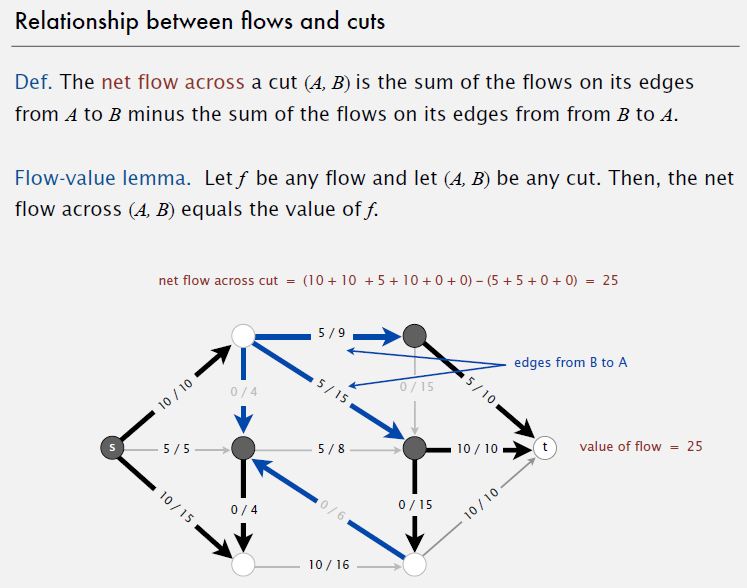

Next, let f be any flow and let (A, B) be any cut. Then, the vlaue of the flow is always <= the capacity of the cut.

<strong>Augmenting path theorem:</strong> A flow f is a maxflow if and only if there are no augmenting paths
<strong>Maxflow-mincut theorem:</strong> The value of the maxflow equals the capacity of the mincut

So, you can compute a mincut from a maxflow in the following way:
* Starting from the source s, find the set of vertices connected to s by an undirected path containing no full forward edges and no empty backward edges
* That's the mincut of the graph

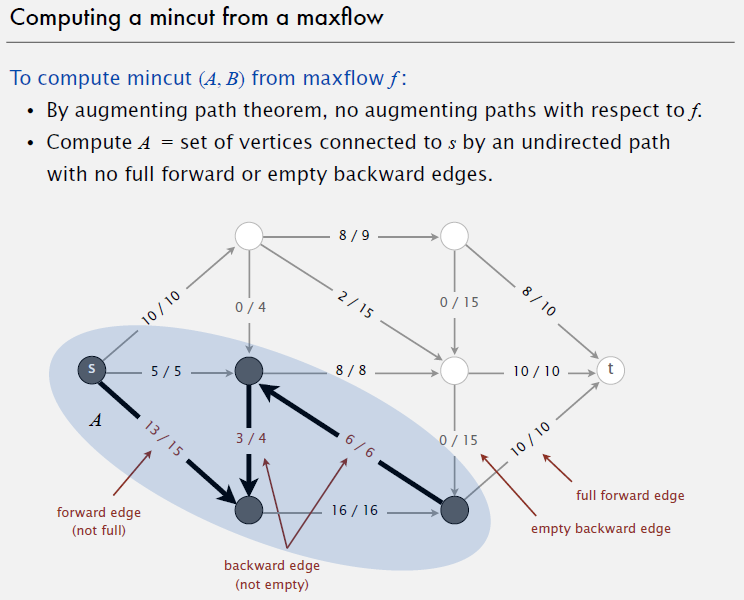

This can be done in <strong>linear time</strong> using either DFS or BFS. Overall performance of the Ford-Fulkerson algorithm depends on how augmenting paths are found.

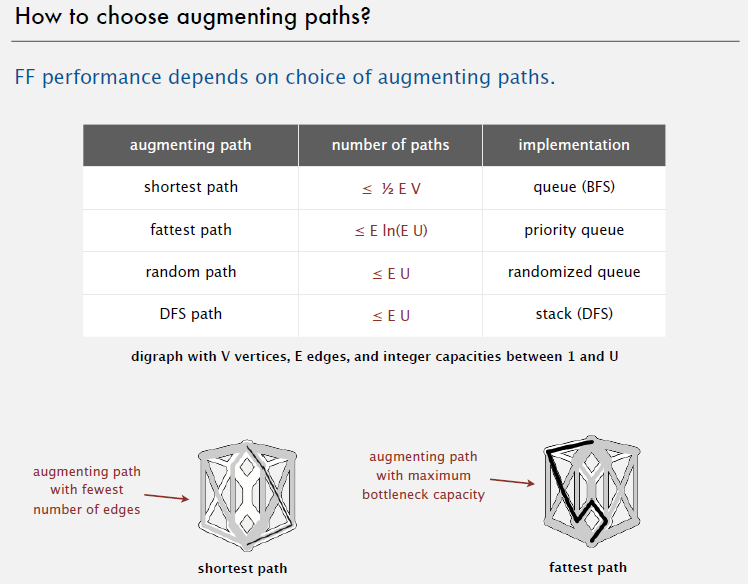

### Implementation

The most complicated graph processing algorithm considered so far!

See code below for additional implementation notes and details, but the key idea is the following:
* In order to enable typical graph processing algorithms to work on this problem, we can represent the flow network graph (with its forward and backward edges), as a <strong>residual graph</strong> instead.
* A residual network is a digraph where forward and backward edges are represented separately and whose weights are 1) capacity - flow for forward edges, and 2) flow for backward edges, each indicating either the additional flow possible through an edge or the flow it is possible to reduce in an edge

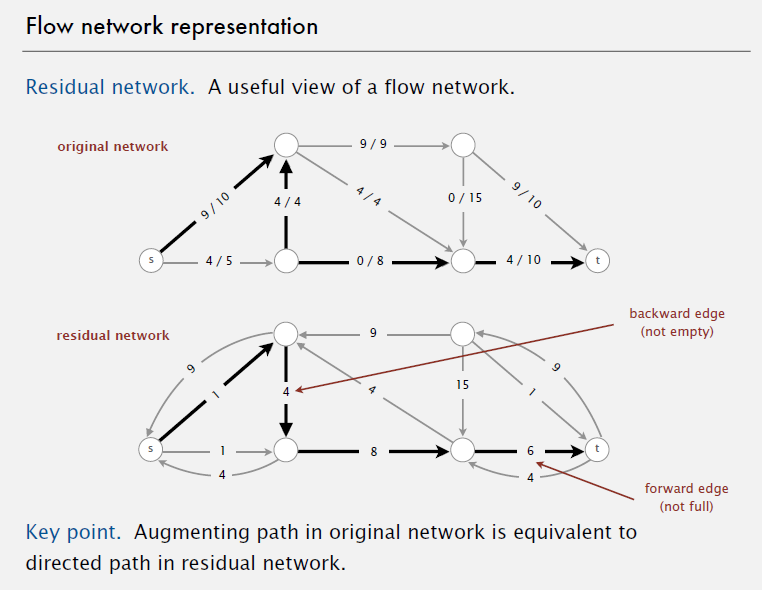

* The result of representing the original graph in this way is that graph processing algorithms like BFS work, and finding paths through the residual graph means finding augmenting paths in the original graph!

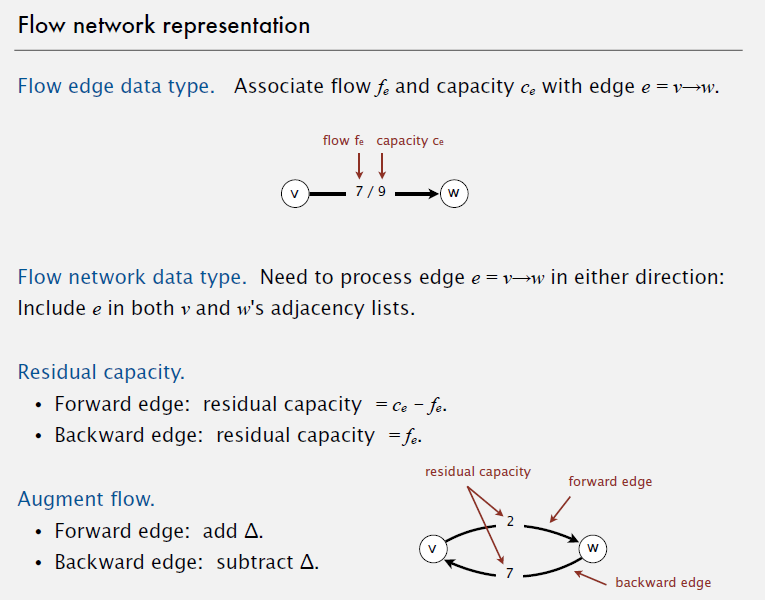

In [44]:
class FlowEdge:
    """Directed edge, with additional support for capacity and flow values"""
    def __init__(self, v, w, capacity):
        self.v = v
        self.w = w
        self.capacity = capacity
        self.flow = 0
        
    def __repr__(self):
        return f'{self.v} -> {self.w} ({self.flow} / {self.capacity})'
    
    def v_from(self):
        return self.v
    
    def v_to(self):
        return self.w
    
    def other(self, v):
        if v == self.v:
            return self.w
        else:
            return self.v
        
    def capacity(self):
        return self.capacity
    
    def flow(self):
        return self.flow
    
    def residual_capacity_to(self, v):
        """Residual capacity towards vertex v. See slides above"""
        if v == self.v:
            """Backward edge"""
            return self.flow
        elif v == self.w:
            """Forward edge"""
            return self.capacity - self.flow
        
    def add_residual_flow_to(self, v, delta):
        """Adds delta flow towards vertex v
        
        If v is the origin vertex, adding residual flow means adding flow
        TOWARDS v (ie, along the backward edge). To do that, subtract the
        delta from the existing flow along the edge.
        
        Adding residual flow towards w is just adding flow as you'd expect.
        """
        if v == self.v:
            """Backward edge"""
            self.flow -= delta
        elif v == self.w:
            """Forward edge"""
            self.flow += delta
    
class FlowNetwork:
    """Somewhat like an undirected graph, because we need to able to process
    edges in BOTH directions
    """
    def __init__(self, V):
        self.V = V
        self.adj = {v: [] for v in range(0, V)}
        self.edges = []
        
    def __repr__(self):
        s = ''
        for edge in self.edges:
            s += f'{edge}\n'
        return s.strip()
    
    def add_edge(self, edge):
        """Even though this is a directed graph, need to add edges to both
        vertices in the adjacency list to support forward and backward
        edge operations
        """
        v = edge.v_from()
        w = edge.v_to()
        self.adj[v].append(edge)
        self.adj[w].append(edge)
        self.edges.append(edge)
        
class FordFulkerson:
    """Implements the Ford Fulkerson algorithm for finding mincut/maxflow"""
    def __init__(self, G, s, t):
        self.G = G
        self.s = s
        self.t = t
        # Vertices in FINAL maxflow residual network
        self.marked = [False for v in range(0, G.V)]
        
        # Last edge on the path from s to v
        self.edge_to = [np.nan for v in range(0, G.V)]
        
        # Final max flow value
        self.flow_value = 0
        
    def get_flow_value(self):
        return self.flow_value
    
    def in_final_cut(self, v):
        return self.maxflow_marked[v]
    
    def FF(self):
        """While there remains an augmenting path:
        Step 1: Compute the path bottleneck
        Step 2: Add the bottleneck value to the network flow
        """
        while self._has_augmenting_path():
            bottleneck = np.inf
            # Trace back from t to s, store bottleneck value
            v = self.t
            while v != self.s:
                bottleneck = min(bottleneck, self.edge_to[v].residual_capacity_to(v))
                v = self.edge_to[v].other(v)
                
            v = self.t
            while v != self.s:
                self.edge_to[v].add_residual_flow_to(v, bottleneck)
                v = self.edge_to[v].other(v)
                
            self.flow_value += bottleneck
            
    def _has_augmenting_path(self):
        """This is just running BFS on the residual graph!
        
        If there is no path from s to t on the residual graph, you've found
        the max flow state and the algorithm should terminate. That state is
        reached when BFS fails, ie, when there is no longer any augmenting
        path on the original graph.
        """
        """Initialise edge_To and marked as usual for BFS--need to reset the
        edge_to and marked arrays to check for new paths with updated flow
        """
        self.edge_to = [np.nan for v in range(0, self.G.V)]
        self.marked = [False for v in range(0, self.G.V)]
        
        """
        Set up and run BFS, with the added condition that we check whether 
        there exists any residual capacity toward w--this is where we're
        actually checking the residual graph of G!!!
        """
        queue = deque()
        queue.appendleft(self.s)
        while len(queue) > 0:
            v = queue.pop()
            for edge in self.G.adj[v]:
                w = edge.other(v)
                if edge.residual_capacity_to(w) > 0 and not self.marked[w]:
                    self.edge_to[w] = edge
                    self.marked[w] = True
                    queue.appendleft(w)
        return self.marked[self.t]

In [45]:
edges = [[0, 1, 2.0],
[0, 2, 3.0],
[1, 3, 3.0],
[1, 4, 1.0],
[2, 3, 1.0],
[2, 4, 1.0],
[3, 5, 2.0],
[4, 5, 3.0],]
FN = FlowNetwork(6)
for edge in edges:
    edge = FlowEdge(edge[0], edge[1], edge[2])
    FN.add_edge(edge)

In [46]:
FN

0 -> 1 (0 / 2.0)
0 -> 2 (0 / 3.0)
1 -> 3 (0 / 3.0)
1 -> 4 (0 / 1.0)
2 -> 3 (0 / 1.0)
2 -> 4 (0 / 1.0)
3 -> 5 (0 / 2.0)
4 -> 5 (0 / 3.0)

In [47]:
ff = FordFulkerson(FN, 0, 5)
ff.FF()

In [48]:
FN

0 -> 1 (2.0 / 2.0)
0 -> 2 (2.0 / 3.0)
1 -> 3 (1.0 / 3.0)
1 -> 4 (1.0 / 1.0)
2 -> 3 (1.0 / 1.0)
2 -> 4 (1.0 / 1.0)
3 -> 5 (2.0 / 2.0)
4 -> 5 (2.0 / 3.0)

In [49]:
ff.flow_value

4.0

### Some Applications of Maxflow

Maxflow is another example of a really powerful problem-solving model that can be applied to many different, seemingly unrelated, problems.

1. Bipartite Matching Problem
    * Create bipartite graph mapping two sets of vertices
    * Create phantom vertices s and t, such that there is an edge from s to each vertex in set 1, and an edge from each vertex in set 2 to t
    * This then becomes a maxflow problem! The flow at the end will show the matchings (if a perfect matching exists), or will show why a perfect match cannot exist
    
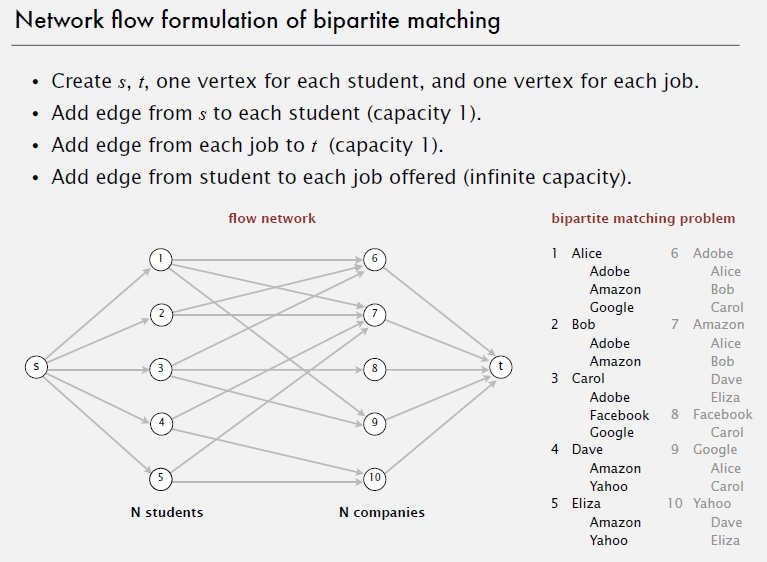

2. Baseball Elimination Problem

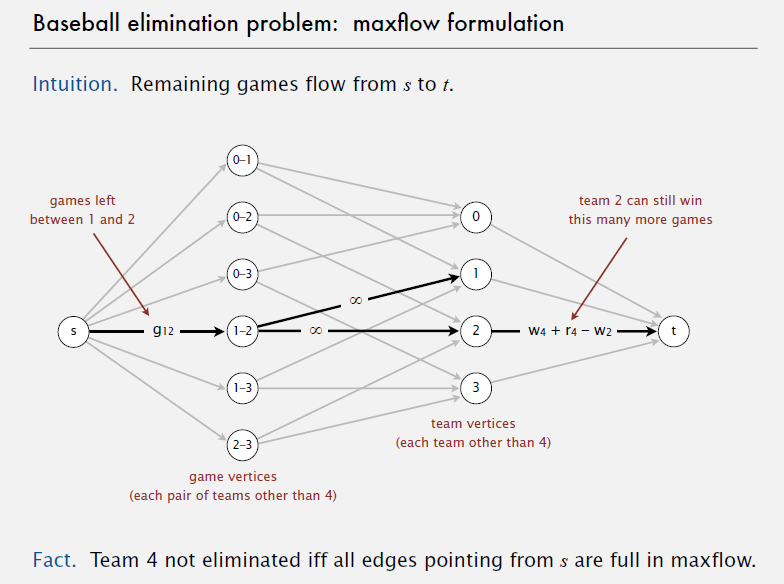

## Maxflow Performance

Note: the theoretical worst-case performance for maxflow algorithms isn't really useful, because in practice, the performance of the algorithm will depend far more on the characteristics of the network (dense, sparse, etc.), given the current state of algorithms used to solve the problem!

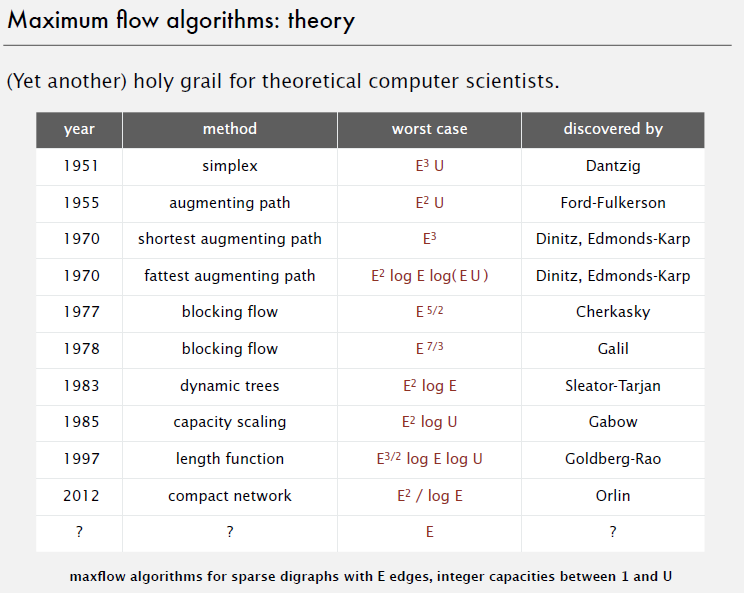